In [1]:
from pathlib import Path
import bz2
import functools
from functools import cached_property
import numpy as np
import matplotlib.pyplot as plt
from random import randint

# Dataset Visualization

Ссылка на dataset: [Bundle Adjustment in the Large](https://grail.cs.washington.edu/projects/bal/)

## Описание

В датасете есть несколько наборов:
- Ladybug
- Trafalgar Square
- Dubrovnik
- Venice
- Final

#### Источники данных
Датасеты собраны с помощью двух источников данных:
- **Ladybug dataset**: Изображения, снятые с обычной частотой с помощью камеры Ladybug, установленной на движущемся транспортном средстве. Сопоставление изображений было выполнено с использованием временного порядка изображений и информации GPS, полученной во время захвата изображения.
- **Other datasets**: Изображения загружены с Flickr.com и сопоставлены с помощью системы, описанной в книге [«Building Rome in a Day»](http://grail.cs.washington.edu/rome/). Мы использовали изображения Трафальгарской площади и городов Дубровника, Венеции и Рима.

#### Формат названия файлов задач (problem)
В каждом датасете есть задачи (problem), они характеризуются количеством картинок, количеством точек и количеством наблюдений. Например, задача с названием `problem-49-7776-pre.txt.bz2` имеет 49 images, 7776 3D points, 31843 observations.

#### Формат данных
Каждая задача предоставляется в виде сжатого текстового файла bzip2 в следующем формате:
```
<num_cameras> <num_points> <num_observations>
<camera_index_1> <point_index_1> <x_1> <y_1>
...
<camera_index_num_observations> <point_index_num_observations> <x_num_observations> <y_num_observations>
<camera_1>
...
<camera_num_cameras>
<point_1>
...
<point_num_points>
```

Под камерой подразумевается одно изображение.
Индексация камер и точек начинаются с 0. 
#### Модель камеры
В датасете используется модель камеры-обскуры (pinhole camera model).

Каждая камера представляет собой набор из 9 параметров: вращение каждой области камеры R, перемещение t, фокусное расстояние f, два параметра радиального искажения k1 и k2. Вращение R задано как [вектор Родригеса](https://en.wikipedia.org/wiki/Rodrigues'_rotation_formula).

##### Формула проецирования трехмерной точки Х в камеру R,t,f,k1,k2

- `P  =  R * X + t`       (преобразование координат мира в координаты камеры)
- `p  = -P / P.z`         (perspective division)
- `p' =  f * r(p) * p`    (преобразование в пиксельные координаты)

где `P.z` - третья `(z)` координата `P`. В последнем уравнении `r(p)` -- это функция, которая вычисляет коэффициент масштабирования для устранения радиального искажения:

`r(p) = 1.0 + k1 * ||p||^2 + k2 * ||p||^4`.

Это дает проекцию в пикселях, где началом координат изображения является центр изображения, положительная ось x указывает вправо, а положительная ось y указывает вверх (кроме того, в системе координат камеры положительная ось z указывает назад, поэтому камера смотрит вниз отрицательная ось z, как в OpenGL).

In [2]:
problem_type = 'ladybug'

bal_folder = Path('../../../dataset')

bal_files = list((bal_folder / problem_type).iterdir())
bal_files = sorted(
    [p for p in bal_files if p.name.endswith('.bz2') and p.name.startswith('problem')], 
    key=lambda p: int(p.name.split('problem-')[1].split('-')[0])
)
bal_files

[PosixPath('../../../dataset/ladybug/problem-49-7776-pre.txt.bz2'),
 PosixPath('../../../dataset/ladybug/problem-73-11032-pre.txt.bz2'),
 PosixPath('../../../dataset/ladybug/problem-138-19878-pre.txt.bz2'),
 PosixPath('../../../dataset/ladybug/problem-318-41628-pre.txt.bz2'),
 PosixPath('../../../dataset/ladybug/problem-372-47423-pre.txt.bz2'),
 PosixPath('../../../dataset/ladybug/problem-412-52215-pre.txt.bz2'),
 PosixPath('../../../dataset/ladybug/problem-460-56811-pre.txt.bz2'),
 PosixPath('../../../dataset/ladybug/problem-539-65220-pre.txt.bz2'),
 PosixPath('../../../dataset/ladybug/problem-598-69218-pre.txt.bz2'),
 PosixPath('../../../dataset/ladybug/problem-646-73584-pre.txt.bz2'),
 PosixPath('../../../dataset/ladybug/problem-707-78455-pre.txt.bz2'),
 PosixPath('../../../dataset/ladybug/problem-783-84444-pre.txt.bz2'),
 PosixPath('../../../dataset/ladybug/problem-810-88814-pre.txt.bz2'),
 PosixPath('../../../dataset/ladybug/problem-856-93344-pre.txt.bz2'),
 PosixPath('../../../da

## Визуализация данных

In [3]:
def read_from_file(file_path: str, bz2_encoding: bool = True):
    """Read BAL file contents & create BAProblem

    Set `bz2_encoding` to `False` if the file archive is unpacked
    """
    open_file = (
            functools.partial(bz2.open, mode='rt')
            if bz2_encoding
            else functools.partial(open, mode='r')
        )
    with open_file(file_path) as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))
        
    return camera_params, points_3d, camera_indices, point_indices, points_2d, n_cameras, n_points, n_observations

### Рассмотрим датасет problem-49-7776-pre.txt.bz2

In [4]:
bal_file = bal_files[0]
bal_file

PosixPath('../../../dataset/ladybug/problem-49-7776-pre.txt.bz2')

In [5]:
problem = bal_file.name.split('problem-')[1].split('-pre')[0]
problem, bal_file

('49-7776', PosixPath('../../../dataset/ladybug/problem-49-7776-pre.txt.bz2'))

#### Прочитаем данные из файла

In [6]:
camera_params, points_3d, camera_indices, point_indices, points_2d, n_cameras, n_points, n_observations = read_from_file(bal_file)

#### Рассмотрим прочитанные данные
##### camera_params

In [7]:
print("Рассмотрим объект camera_params размерности = {}.".format(camera_params.shape))
print("Количество камер (изображений) = {}. \nКоличество камер соответствует названию файла.".format(camera_params.shape[0]))
print("Kоличество параметров, описанных выше у каждой камеры = {}.".format(camera_params.shape[1]))

Рассмотрим объект camera_params размерности = (49, 9).
Количество камер (изображений) = 49. 
Количество камер соответствует названию файла.
Kоличество параметров, описанных выше у каждой камеры = 9.


##### points_3d

Рассмотрим объект points_3d размерности = (7776, 3).
Количество 3D точек = 7776. 
Количество 3D точек соответствует названию файла.
Размерность каждой 3D точки = 3.


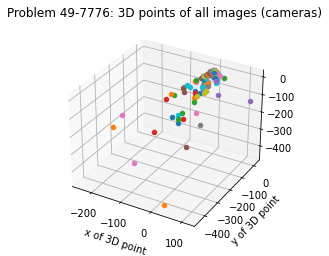

In [8]:
print("Рассмотрим объект points_3d размерности = {}.".format(points_3d.shape))
print("Количество 3D точек = {}. \nКоличество 3D точек соответствует названию файла.".format(points_3d.shape[0]))
print("Размерность каждой 3D точки = {}.".format(points_3d.shape[1]))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for point_3d in points_3d:
    ax.scatter(*point_3d)
    
plt.title("Problem {}: 3D points of all images (cameras)".format(problem))
plt.xlabel("x of 3D point")
plt.ylabel("y of 3D point")
# plt.zlabel("z of 3D point")
plt.show()

##### points_2d, point_indices, camera_indices

In [9]:
print("Рассмотрим объект points_2d размерности = {}.".format(points_2d.shape))
print("Количество 2D точек всего со всех камер = {}.".format(points_2d.shape[0]))
print("Размерность каждой 2D точки = {}.\n\n".format(points_2d.shape[1]))

print("Каждая 2D точка определяется индексом камеры (изображения) и индексом точки: camera_indices и point_indices.\n")

print("Рассмотрим объект camera_indices размерности = {}".format(camera_indices.shape))
print("Количество индексов камер = {} и совпадает с количеством 2D точек.".format(camera_indices.shape[0]))
print("camera_indices содержит индексы камер. Индексы могут повторятся, так как одно изображение (камера), содержит много 2D точек. Индексы камер соответствуют camera_params")
print("Часть содержимого camera_indices = {}.\n".format(camera_indices[:10]))

print("Рассмотрим объект point_indices размерности = {}".format(point_indices.shape))
print("Количество индексов точек = {} и совпадает с количеством 2D точек.".format(point_indices.shape[0]))
print("point_indices содержит индексы точек. Индексы могут повторятся, так как несколько изображений (камер), содержат одинаковые 2D точки. Индексы точек соответствуют points_2d")
print("Часть содержимого point_indices = {}.\n".format(point_indices[:10]))

Рассмотрим объект points_2d размерности = (31843, 2).
Количество 2D точек всего со всех камер = 31843.
Размерность каждой 2D точки = 2.


Каждая 2D точка определяется индексом камеры (изображения) и индексом точки: camera_indices и point_indices.

Рассмотрим объект camera_indices размерности = (31843,)
Количество индексов камер = 31843 и совпадает с количеством 2D точек.
camera_indices содержит индексы камер. Индексы могут повторятся, так как одно изображение (камера), содержит много 2D точек. Индексы камер соответствуют camera_params
Часть содержимого camera_indices = [ 0  1  3 26 29 36  0  1  4  8].

Рассмотрим объект point_indices размерности = (31843,)
Количество индексов точек = 31843 и совпадает с количеством 2D точек.
point_indices содержит индексы точек. Индексы могут повторятся, так как несколько изображений (камер), содержат одинаковые 2D точки. Индексы точек соответствуют points_2d
Часть содержимого point_indices = [0 0 0 0 0 0 1 1 1 1].



#### Визуализация 2D точек

In [8]:
colors = []
n = n_cameras
for i in range(n):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

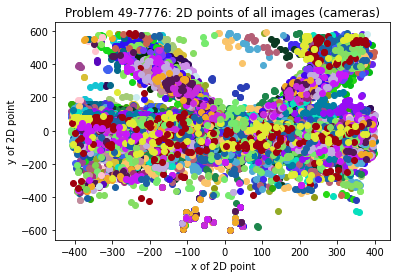

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(len(camera_indices)):
    ax.scatter(points_2d[i][0],points_2d[i][1], color=colors[camera_indices[i]])
    
plt.title("Problem {}: 2D points of all images (cameras)".format(problem))
plt.xlabel("x of 2D point")
plt.ylabel("y of 2D point")
plt.show()

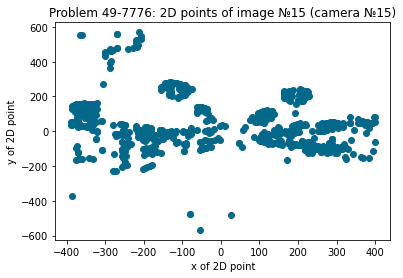

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, )

camera_index = 15
for i in range(len(camera_indices)):
    if camera_indices[i] == camera_index:
        ax.scatter(points_2d[i][0],points_2d[i][1], color=colors[camera_indices[i]])
        
plt.title("Problem {}: 2D points of image №{} (camera №{})".format(problem, camera_index, camera_index))
plt.xlabel("x of 2D point")
plt.ylabel("y of 2D point")
plt.show()

#### Визуализация позиций камер

In [13]:
camera_poses = camera_params[:, 3:6]
print("Рассмотрим объект camera_poses размерности = {}, \nгде количество камер = {}, а позиция камер размерности = {}".format(camera_poses.shape, camera_poses.shape[0], camera_poses.shape[1]))

Рассмотрим объект camera_poses размерности = (49, 3), 
где количество камер = 49, а позиция камер размерности = 3


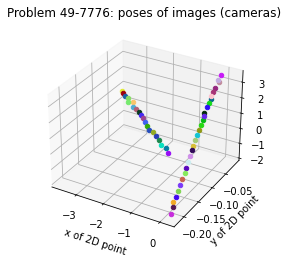

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

camera_index = 0
for pose in camera_poses:
    ax.scatter(*pose, color=colors[camera_index]) 
    camera_index += 1
plt.title("Problem {}: poses of images (cameras)".format(problem))
plt.xlabel("x of 2D point")
plt.ylabel("y of 2D point")
plt.show()

#### Параметры камеры: f

In [15]:
camera_f = camera_params[:, 6]
camera_f

array([399.75152639, 402.01753386, 399.45202818, 400.40175368,
       399.33701787, 402.53499182, 398.94934289, 402.79146963,
       398.32357103, 397.65753359, 403.5860929 , 403.03786377,
       396.89589573, 404.60249763, 397.27542715, 395.89506545,
       406.82971524, 395.38824687, 406.97517827, 407.51675372,
       395.86596285, 407.9833193 , 405.57115735, 407.66743469,
       406.80183694, 405.86445539, 407.03024568, 406.21192658,
       406.46269844, 405.91764962, 408.11486642, 405.25634838,
       402.99957603, 395.8574347 , 408.60658922, 395.75073104,
       404.73590637, 403.35634682, 395.82399779, 410.61840999,
       402.67502355, 402.98882321, 401.58414075, 408.58939576,
       402.78411073, 410.51141222, 402.3011129 , 395.27331372,
       403.85565612])

### Рассмотрим датасет problem-49-7776-pre.txt.bz2

In [101]:
bal_file = bal_files[30]
bal_file

PosixPath('../../../dataset/ladybug/problem-1723-156502-pre.txt.bz2')

In [102]:
problem = bal_file.name.split('problem-')[1].split('-pre')[0]
problem, bal_file

('1723-156502',
 PosixPath('../../../dataset/ladybug/problem-1723-156502-pre.txt.bz2'))

#### Прочитаем данные из файла

In [79]:
camera_params, points_3d, camera_indices, point_indices, points_2d, n_cameras, n_points, n_observations = read_from_file(bal_file)

#### Рассмотрим прочитанные данные
##### camera_params

In [63]:
print("Рассмотрим объект camera_params размерности = {}.".format(camera_params.shape))
print("Количество камер (изображений) = {}. \nКоличество камер соответствует названию файла.".format(camera_params.shape[0]))
print("Kоличество параметров, описанных выше у каждой камеры = {}.".format(camera_params.shape[1]))

Рассмотрим объект camera_params размерности = (49, 9).
Количество камер (изображений) = 49. 
Количество камер соответствует названию файла.
Kоличество параметров, описанных выше у каждой камеры = 9.


##### points_3d

Рассмотрим объект points_3d размерности = (7776, 3).
Количество 3D точек = 7776. 
Количество 3D точек соответствует названию файла.
Размерность каждой 3D точки = 3.


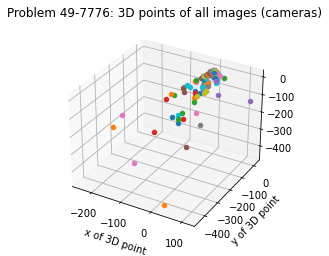

In [105]:
print("Рассмотрим объект points_3d размерности = {}.".format(points_3d.shape))
print("Количество 3D точек = {}. \nКоличество 3D точек соответствует названию файла.".format(points_3d.shape[0]))
print("Размерность каждой 3D точки = {}.".format(points_3d.shape[1]))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for point_3d in points_3d:
    ax.scatter(*point_3d)
    
plt.title("Problem {}: 3D points of all images (cameras)".format(problem))
plt.xlabel("x of 3D point")
plt.ylabel("y of 3D point")
# plt.zlabel("z of 3D point")
plt.show()

##### points_2d, point_indices, camera_indices

In [74]:
print("Рассмотрим объект points_2d размерности = {}.".format(points_2d.shape))
print("Количество 2D точек всего со всех камер = {}.".format(points_2d.shape[0]))
print("Размерность каждой 2D точки = {}.\n\n".format(points_2d.shape[1]))

print("Каждая 2D точка определяется индексом камеры (изображения) и индексом точки: camera_indices и point_indices.\n")

print("Рассмотрим объект camera_indices размерности = {}".format(camera_indices.shape))
print("Количество индексов камер = {} и совпадает с количеством 2D точек.".format(camera_indices.shape[0]))
print("camera_indices содержит индексы камер. Индексы могут повторятся, так как одно изображение (камера), содержит много 2D точек. Индексы камер соответствуют camera_params")
print("Часть содержимого camera_indices = {}.\n".format(camera_indices[:10]))

print("Рассмотрим объект point_indices размерности = {}".format(point_indices.shape))
print("Количество индексов точек = {} и совпадает с количеством 2D точек.".format(point_indices.shape[0]))
print("point_indices содержит индексы точек. Индексы могут повторятся, так как несколько изображений (камер), содержат одинаковые 2D точки. Индексы точек соответствуют points_2d")
print("Часть содержимого point_indices = {}.\n".format(point_indices[:10]))

Рассмотрим объект points_2d размерности = (31843, 2).
Количество 2D точек всего со всех камер = 31843.
Размерность каждой 2D точки = 2.


Каждая 2D точка определяется индексом камеры (изображения) и индексом точки: camera_indices и point_indices.

Рассмотрим объект camera_indices размерности = (31843,)
Количество индексов камер = 31843 и совпадает с количеством 2D точек.
camera_indices содержит индексы камер. Индексы могут повторятся, так как одно изображение (камера), содержит много 2D точек. Индексы камер соответствуют camera_params
Часть содержимого camera_indices = [ 0  1  3 26 29 36  0  1  4  8].

Рассмотрим объект point_indices размерности = (31843,)
Количество индексов точек = 31843 и совпадает с количеством 2D точек.
point_indices содержит индексы точек. Индексы могут повторятся, так как несколько изображений (камер), содержат одинаковые 2D точки. Индексы точек соответствуют points_2d
Часть содержимого point_indices = [0 0 0 0 0 0 1 1 1 1].



#### Визуализация 2D точек

In [80]:
colors = []
n = n_cameras
for i in range(n):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(len(camera_indices)):
    ax.scatter(points_2d[i][0],points_2d[i][1], color=colors[camera_indices[i]])
    
plt.title("Problem {}: 2D points of all images (cameras)".format(problem))
plt.xlabel("x of 2D point")
plt.ylabel("y of 2D point")
plt.show()

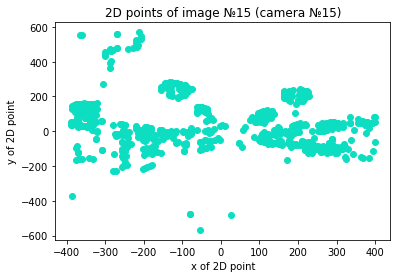

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111, )

camera_index = 15
for i in range(len(camera_indices)):
    if camera_indices[i] == camera_index:
        ax.scatter(points_2d[i][0],points_2d[i][1], color=colors[camera_indices[i]])
        
plt.title("Problem {}: 2D points of image №{} (camera №{})".format(problem, camera_index, camera_index))
plt.xlabel("x of 2D point")
plt.ylabel("y of 2D point")
plt.show()

#### Визуализация позиций камер

In [96]:
camera_poses = camera_params[:, 3:6]
print("Рассмотрим объект camera_poses размерности = {}, \nгде количество камер = {}, а позиция камер размерности = {}".format(camera_poses.shape, camera_poses.shape[0], camera_poses.shape[1]))

Рассмотрим объект camera_poses размерности = (49, 3), 
где количество камер = 49, а позиция камер размерности = 3


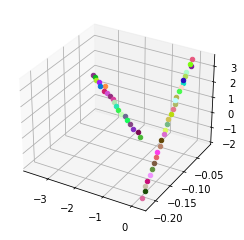

In [97]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

camera_index = 0
for pose in camera_poses:
    ax.scatter(*pose, color=colors[camera_index]) 
    camera_index += 1
plt.title("Problem {}: poses of images (cameras)".format(problem))
plt.xlabel("x of 2D point")
plt.ylabel("y of 2D point")
plt.show()